In [1]:
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.generation import MaxPosteriorSampling
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

from torch.quasirandom import SobolEngine
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from botorch.utils.transforms import unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from src.sim import MixtureModel
import matplotlib.pyplot as plt

import math
from natsort import natsorted
from dataclasses import dataclass

import glob
from PIL import Image

%load_ext autoreload
%autoreload 2

In [5]:
device = torch.device("cpu")
dtype = torch.float

In [6]:
sim = MixtureModel(concentrations=[1., 0.])
P = 80
T_start, T_end = 200, 400
T_span = np.linspace(T_start, T_end, T_end - T_start + 1)
res = sim.get_density(P, T_span)

Getting too close to iteration limit. Exiting...


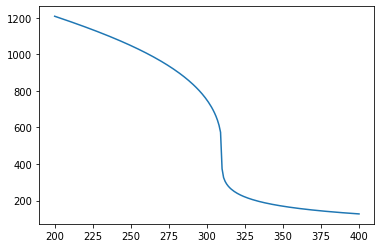

In [7]:
plt.plot(T_span, res)

In [8]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to()
    return X_init
    
def central_differences(P, T, norm=True):
    if norm:
        P, T = unnormalize(P, (lb_P, ub_P)), unnormalize(T, (lb_T, ub_T))

    T_start, T_end = T-0.3, T+0.3
    T_span = np.linspace(T_start, T_end, 2)
    res = sim.get_density(P, T_span)

    dddT = (res[-1] - res[0]) / 2
    dddT = torch.tensor(dddT)
    return dddT

def eval_objective(x):
    x = x.numpy()
    """This is a helper function we use to unnormalize and evaluate a point"""
    P, T = x
    return -central_differences(P, T)

central_differences(1, 0.5)

tensor(-2.7584, dtype=torch.float64)

## GP-EI

In [44]:
lb_T, ub_T = 260, 360
lb_P, ub_P = 60, 120
dim = 2
batch_size = 1
n_init = 2
n_iters = 50
NUM_RESTARTS = 40 
RAW_SAMPLES = 512 
N_CANDIDATES = min(5000, max(2000, 200 * dim)) 
max_cholesky_size = float("inf")  # Always use Cholesky

In [45]:
X_ei = get_initial_points(dim, n_init, seed=2)
Y_ei = torch.tensor(
    [eval_objective(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

while len(Y_ei) < n_iters:
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

3) Best value: 1.49e+00
4) Best value: 1.49e+00
5) Best value: 2.34e+00
6) Best value: 2.34e+00
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
7) Best value: 2.34e+00
8) Best value: 2.34e+00
9) Best value: 2.34e+00
10) Best value: 2.72e+00
11) Best value: 2.72e+00
12) Best value: 4.23e+00
13) Best value: 4.23e+00
14) Best value: 4.66e+00
15) Best value: 4.66e+00
16) Best value: 5.28e+00
17) Best value: 5.37e+00
18) Best value: 5.37e+00
19) Best value: 5.48e+00
20) Best value: 5.48e+00
21) Best value: 5.87e+00
22) Best value: 6.44e+00
23) Best value: 7.48e+00
24) Best value: 9.50e+00
25) Best value: 9.50e+00
26) Best value: 1.06e+01
27) Best value: 1.06e+01
28) Best value: 1.06e+01
29) Best value: 1.06e+01
30) Best value: 1.13e+01
31) Best value: 1.13e+01
32) Best value: 1.22e+01
33) Best value: 1.25e+01
34) Best value: 1.27e+01
35) Best value: 1.28e+01
36) Best value: 1.34e+01
37) Best value: 1.34e+01
38) Best value: 1.39e+01
39) Best 

/home/stefano/michael/diffeqml/bo-phases/src/PCSAFT.py:491: RuntimeWarning: invalid value encountered in log
  fug[i] = np.exp(mu_assoc[i] + mu_hc[i] + mu_disp[i] - np.log(Z))


40) Best value: 1.39e+01
41) Best value: 1.48e+01
42) Best value: 1.56e+01
43) Best value: 1.64e+01
44) Best value: 1.65e+01
45) Best value: 1.65e+01
46) Best value: 1.80e+01
47) Best value: 1.86e+01
Getting too close to iteration limit. Exiting...


/home/stefano/michael/diffeqml/bo-phases/src/PCSAFT.py:491: RuntimeWarning: invalid value encountered in log
  fug[i] = np.exp(mu_assoc[i] + mu_hc[i] + mu_disp[i] - np.log(Z))


Getting too close to iteration limit. Exiting...
48) Best value: 1.86e+01
49) Best value: 1.86e+01
50) Best value: 1.86e+01


### Plot

In [11]:
def draw_state_space(P_span, T_span):
    sim = MixtureModel(concentrations=[1., 0.])
    res = []
    est_dddT = []
    for P in P_span:
        res.append(sim.get_density(P, T_span))

    return np.array(res) 

In [12]:
P_span = np.arange(lb_P, ub_P, 1)
T_span = np.arange(lb_T, ub_T, 1)
res = draw_state_space(P_span, T_span)

Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...


/home/stefano/michael/diffeqml/bo-phases/src/PCSAFT.py:491: RuntimeWarning: invalid value encountered in log
  fug[i] = np.exp(mu_assoc[i] + mu_hc[i] + mu_disp[i] - np.log(Z))


Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to

In [46]:
sim = MixtureModel(concentrations=[1., 0.])

for k in range(0, n_iters-n_init):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    im = ax.contourf(T_span, P_span, res, levels=100, cmap='bone')
    im1 = ax.scatter(
        unnormalize(X_ei[:n_init, 1], (lb_T, ub_T)), unnormalize(X_ei[:n_init, 0], (lb_P, ub_P)),
        color='black', marker='1', s=300
       )
    P, T = X_ei[n_init+k, 0], X_ei[n_init+k, 1]
    im2 = ax.scatter(
        unnormalize(T, (lb_T, ub_T)), unnormalize(P, (lb_P, ub_P)),
        color='blue', alpha=0.9, marker='p', s=400
        )

    P_pre, T_pre = X_ei[n_init:n_init+k, 0], X_ei[n_init:n_init+k, 1]
    im3 = ax.scatter(
        unnormalize(T_pre, (lb_T, ub_T)), unnormalize(P_pre, (lb_P, ub_P)),
        color='gray', alpha=1, marker='p', s=100
        )
    ax.set_xlim(lb_T - 1, ub_T + 1)
    ax.set_ylim(lb_P - 1, ub_P + 1)

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Pressure (bar)")
    ax.set_title(f"Iteration: {k}")

    #plt.colorbar(im)   

    # find and color best so far
    best_y_idx = Y_ei[:k+n_init].argmax()
    P_best, T_best = unnormalize(X_ei[best_y_idx, 0], (lb_P, ub_P)), unnormalize(X_ei[best_y_idx, 1], (lb_T, ub_T))
    im4 = ax.scatter(T_best, P_best, alpha=0.9, marker='s', s=300, facecolors='none', edgecolors='r')

    # plot last move
    P_move, T_move = X_ei[n_init+k-1:n_init+k+1, 0], X_ei[n_init+k-1:n_init+k+1, 1]
    im3 = ax.plot(
        unnormalize(T_move, (lb_T, ub_T)), unnormalize(P_move, (lb_P, ub_P)),
        color='gray', alpha=0.6, linewidth=2,
        )
    ax.set_xlim(lb_T - 1, ub_T + 1)
    ax.set_ylim(lb_P - 1, ub_P + 1) 

    # plt.grid()
    plt.savefig(f'artifacts/plots/bo_exploration/exploration_{k}.jpeg', dpi=200, bbox_inches='tight', transparent=False)
    plt.close()

    # plot actual density curve (according to PC-SAFT)
    fig, ax = plt.subplots(1,1,figsize=(7,4))
    T_span_fine = np.linspace(lb_T, ub_T, 100)
    best_curve = np.array(sim.get_density(P_best.numpy(), T_span_fine)) 

    ax.set_ylim(200, 1000)  
    ax.vlines(T_best, ymin=200, ymax=1000, color='red', linestyle='--') # should be T_best, all inverted -_-
    ax.plot(T_span_fine, best_curve, alpha=1, color='black')
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Density (kg / m3)")
    ax.set_title(f"Iter.: {k}, Pressure: {P_best:.1f}, Temp.: {T_best:.1f}")

    #plt.grid()
    plt.savefig(f'artifacts/plots/bo_exploration/density_{k}.jpeg', dpi=200, bbox_inches='tight', transparent=False)
    plt.close()

Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...


/home/stefano/michael/diffeqml/bo-phases/src/PCSAFT.py:491: RuntimeWarning: invalid value encountered in log
  fug[i] = np.exp(mu_assoc[i] + mu_hc[i] + mu_disp[i] - np.log(Z))


Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...
Getting too close to iteration limit. Exiting...


In [543]:
def make_bo_gif(run_id, frame_folder):
    frames = [Image.open(image) for image in natsorted(glob.glob(f"{frame_folder}/exploration*.png"))]
    frame_one = frames[0]
    frame_one.save(f"bo_run_{run_id}.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)

    frames = [Image.open(image) for image in natsorted(glob.glob(f"{frame_folder}/density*.png"))]
    frame_one = frames[0]
    frame_one.save(f"density_{run_id}.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)

In [544]:
frame_folder = 'artifacts/plots/bo_exploration'


make_bo_gif(run_id=1, frame_folder=frame_folder)